<h3>Computer Vision Libraries</h3>

torchvision - datasets, model architectures, image transformations\
torchvision.datasets - datasets for image classification, object detection, etc., and base classes for custom datasets\
torchvision.models - computer vision model architectures\
torchvision.transforms - transformations for processing, augmenting, etc.\
torch.utils.data.Dataset - base dataset class\
torch.utils.data.DataLoader - creates iterable over a dataset

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

<h3>FashionMNIST Data</h3>

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(), # PIL formatted images to tensors
    target_transform=None # for transforming labels
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [4]:
# [color_channel, height, width]
image.shape

torch.Size([1, 28, 28])

In [5]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, '9')

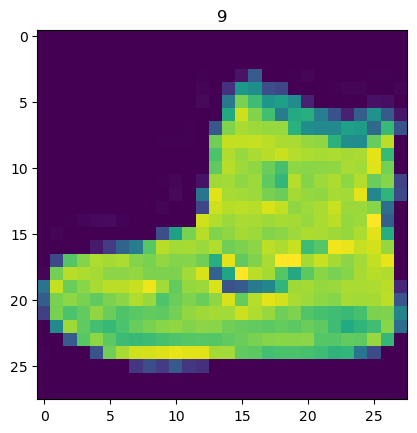

In [7]:
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

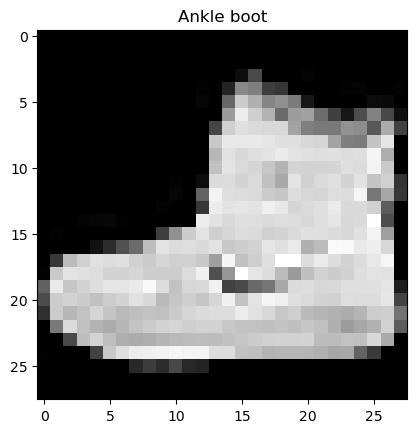

In [8]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])

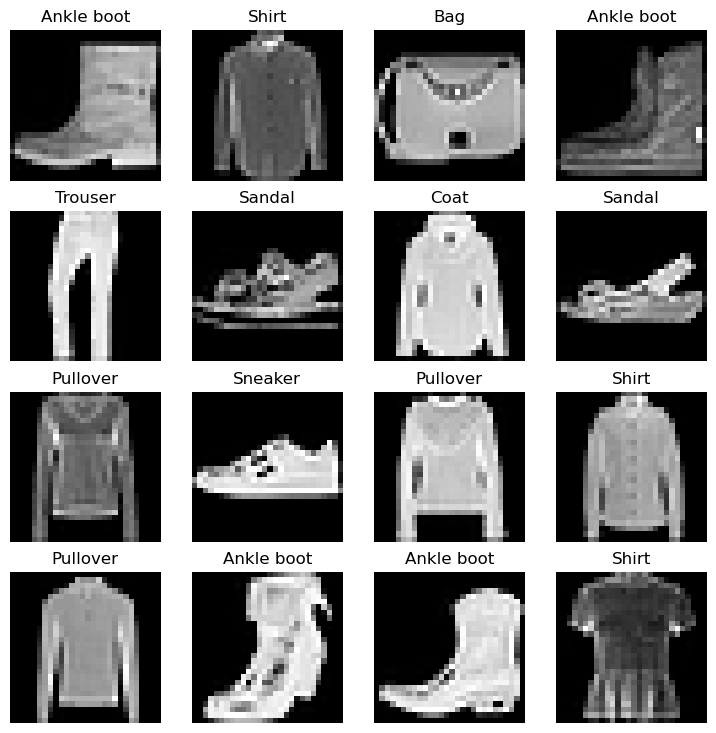

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

<h3>DataLoader</h3>

* DataLoader turns a Dataset into an iterable of smaller chunks (batches/mini-batches) set by batch_size parameter
* Batches better for limited compute power
* Gradient descent performed per batch rather than per epoch
* 32 is a decent batch size, with other common sizes being powers of 2

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, # dataset to turn into an iterable
                              batch_size=BATCH_SIZE, # samples per batch
                              shuffle=True) # shuffle data every epoch

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f'Dataloaders: {train_dataloader, test_dataloader}')
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000019B0EE08E30>, <torch.utils.data.dataloader.DataLoader object at 0x0000019B0ED94320>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

<h3>Build Baseline Model</h3>

In [12]:
# nn.Flatten() useful to turn data into feature vectors
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [13]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784, # 1 for every pixel (28 x 28)
                              hidden_units=10, 
                              output_shape=len(class_names)) # 1 for every class
model_0.to('cpu')

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [16]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device=None):
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')

    return total_time

In [17]:
from tqdm.auto import tqdm
import torchmetrics

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3
accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to('cpu')

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------')
    # Train
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')
    train_loss /= len(train_dataloader)

    # Test
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy(test_pred, y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        # torchmetrics.Accuracy returns decimal
        test_acc *= 100
    print(f'\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n')

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 130.463 seconds


<h3>Predictions and Model 0 Results</h3>

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred, y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {'model_name': model.__class__.__name__,
            'model_loss': loss.item(),
            'model_acc': acc.item() * 100}

In [20]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy, device='cpu')
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4766388535499573,
 'model_acc': 83.42651724815369}

<h3>Model 1 with non-linearity</h3>

In [21]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [22]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [24]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_acc *= 100
    print(f'Train loss {train_loss:.5f} | Train accuracy: {train_acc:.2f}%')

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred, y)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_acc *= 100
        print(f'Test loss {test_loss:.5f} | Test accuracy: {test_acc:.2f}%')

In [25]:
torch.manual_seed(42)

accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

train_time_start_on_gpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch} \n---------')
    train_step(model=model_1, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy)
    test_step(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 
---------
Train loss 1.09199 | Train accuracy: 61.34%
Test loss 0.95636 | Test accuracy: 65.00%
Epoch 1 
---------
Train loss 0.78101 | Train accuracy: 71.93%
Test loss 0.72227 | Test accuracy: 73.91%
Epoch 2 
---------
Train loss 0.67027 | Train accuracy: 75.94%
Test loss 0.68500 | Test accuracy: 75.02%
Train time on cuda: 165.886 seconds


Although GPU training time took longer due to copying data from CPU to GPU, GPU speedup is more evident in larger datasets and models.

In [26]:
torch.manual_seed(42)

model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy, device=device)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996755599976}

In [27]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4766388535499573,
 'model_acc': 83.42651724815369}

<h3>Model 2: Building a Convolutional Neural Network (CNN)</h3>

input layer -> [ convolutional layer -> activation layer -> pooling layer ] -> output layer

In [28]:
# copy pasta-ing TinyVGG
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # size of square going over the image
                      stride=1, # default, how much the kernel moves
                      padding=1), # 'valid' (no padding) or 'same' (output has same shape as input) or int for specific number or tuple (height, width)
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride=kernel_size means non-overlapping
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 7*7 because input is 28*28 and each MaxPool halves the size, so 28 -> 14 -> 7
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [29]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

nn.Conv1d for 1D data, text\
nn.Conv2d for 2D data, images with (height, width)\
nn.Conv3d for 3D data/objects

<h3>Stepping through nn.Conv2D()</h3>

In [30]:
torch.manual_seed(42)
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0]
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [31]:
torch.manual_seed(42)

conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
conv_layer(test_image)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [32]:
conv_layer(test_image).shape

torch.Size([10, 62, 62])

In [33]:
torch.manual_seed(42)

conv_layer_2 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5, 5), stride=2, padding=0)
print(conv_layer_2(test_image).shape) # [color_channels, height, width]

torch.Size([10, 30, 30])


In [34]:
print(conv_layer_2.state_dict())

OrderedDict({'weight': tensor([[[[ 0.0883,  0.0958, -0.0271,  0.1061, -0.0253],
          [ 0.0233, -0.0562,  0.0678,  0.1018, -0.0847],
          [ 0.1004,  0.0216,  0.0853,  0.0156,  0.0557],
          [-0.0163,  0.0890,  0.0171, -0.0539,  0.0294],
          [-0.0532, -0.0135, -0.0469,  0.0766, -0.0911]],

         [[-0.0532, -0.0326, -0.0694,  0.0109, -0.1140],
          [ 0.1043, -0.0981,  0.0891,  0.0192, -0.0375],
          [ 0.0714,  0.0180,  0.0933,  0.0126, -0.0364],
          [ 0.0310, -0.0313,  0.0486,  0.1031,  0.0667],
          [-0.0505,  0.0667,  0.0207,  0.0586, -0.0704]],

         [[-0.1143, -0.0446, -0.0886,  0.0947,  0.0333],
          [ 0.0478,  0.0365, -0.0020,  0.0904, -0.0820],
          [ 0.0073, -0.0788,  0.0356, -0.0398,  0.0354],
          [-0.0241,  0.0958, -0.0684, -0.0689, -0.0689],
          [ 0.1039,  0.0385,  0.1111, -0.0953, -0.1145]]],


        [[[-0.0903, -0.0777,  0.0468,  0.0413,  0.0959],
          [-0.0596, -0.0787,  0.0613, -0.0467,  0.0701],


In [35]:
print(f'conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]')
print(f'\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]')

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


<h3>Stepping through nn.MaxPool2d()</h3>

In [36]:
# original image shape
print(f'Test image original shape: {test_image.shape}')
print(f'Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}')

# max pool layer example
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass image through convolution layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f'Shape after going through conv_layer(): {test_image_through_conv.shape}')

# pass image through max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [37]:
torch.manual_seed(42)

random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value 

max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


Data is being compressed through the neural network from higher dimensional space to lower dimensional space

In [38]:
avg_pool_layer = nn.AvgPool2d(kernel_size=2)
avg_pool_tensor = avg_pool_layer(random_tensor)
print((avg_pool_tensor == (random_tensor.sum() / 4)).item())

True


In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [40]:
torch.manual_seed(42)
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n---------')
    train_step(model=model_2, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy, device=device)
    test_step(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy, device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end=train_time_end_model_2, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss 0.59050 | Train accuracy: 78.62%
Test loss 0.39891 | Test accuracy: 85.80%
Epoch: 1
---------
Train loss 0.35940 | Train accuracy: 87.03%
Test loss 0.34808 | Test accuracy: 87.23%
Epoch: 2
---------
Train loss 0.32297 | Train accuracy: 88.21%
Test loss 0.31583 | Test accuracy: 88.72%
Train time on cuda: 192.115 seconds


In [41]:
model_2_results = eval_model(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3158330023288727,
 'model_acc': 88.7180507183075}

<h3>Compare Results</h3>

In [42]:
import pandas as pd
results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
results['training time'] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
results

,model_name,model_loss,model_acc,training time
0,FashionMNISTModelV0,0.476639,83.426517,130.463047
1,FashionMNISTModelV1,0.685001,75.019968,165.885690
2,FashionMNISTModelV2,0.315833,88.718051,192.114858


The TinyVGG CNN performed best but had the longest training time

Text(0, 0.5, 'model')

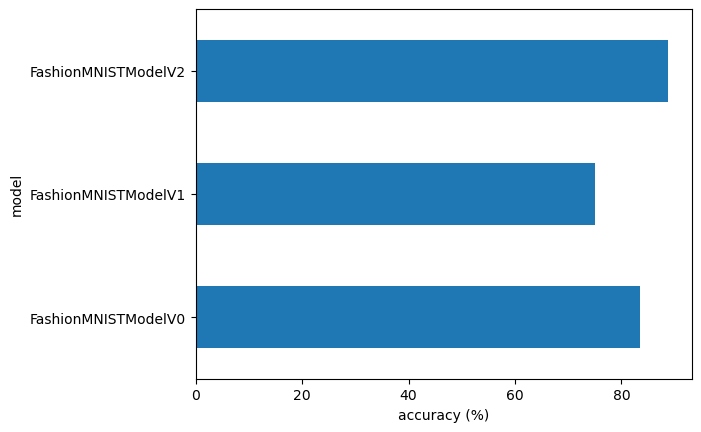

In [43]:
results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [44]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # batch size is 1, softmax on logits dimension not batch dimension
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [45]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=1000):
    test_samples.append(sample)
    test_labels.append(label)

print(f'Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})')

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [46]:
pred_probs = make_predictions(model=model_2, data=test_samples)
pred_probs[:2]

tensor([[2.1274e-08, 4.0177e-08, 2.2068e-08, 1.6140e-08, 3.0280e-09, 9.9992e-01,
         5.6685e-08, 3.6924e-06, 1.4853e-05, 6.0341e-05],
        [6.0864e-02, 6.2688e-01, 1.9792e-03, 1.8434e-01, 7.9030e-02, 1.3786e-04,
         4.5599e-02, 4.1926e-04, 5.9355e-04, 1.5662e-04]])

In [47]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1, 9, 7, 2, 0, 1, 0, 3, 5, 4, 4, 4, 6, 3, 2, 2,
        0, 1, 1, 5, 6, 0, 1, 2, 2, 1, 4, 4, 5, 6, 6, 4, 3, 1, 4, 3, 4, 9, 4, 2,
        9, 7, 0, 4, 0, 5, 6, 2, 7, 8, 5, 8, 9, 8, 5, 6, 0, 9, 2, 6, 3, 2, 0, 0,
        3, 4, 7, 0, 9, 6, 4, 7, 4, 7, 0, 0, 2, 4, 0, 2, 9, 2, 4, 2, 4, 6, 7, 6,
        9, 7, 9, 7, 9, 5, 0, 6, 0, 8, 8, 7, 8, 2, 6, 4, 3, 8, 6, 1, 8, 8, 3, 7,
        2, 6, 1, 3, 0, 8, 3, 4, 9, 3, 1, 8, 7, 3, 1, 9, 6, 8, 0, 1, 6, 0, 4, 4,
        0, 2, 6, 2, 1, 0, 7, 3, 4, 3, 4, 7, 0, 5, 8, 2, 0, 3, 5, 0, 4, 9, 3, 9,
        5, 0, 8, 4, 1, 0, 5, 9, 6, 0, 4, 4, 9, 5, 3, 9, 5, 9, 6, 6, 0, 0, 0, 4,
        4, 6, 7, 8, 6, 4, 8, 3, 6, 9, 5, 3, 5, 5, 2, 4, 6, 0, 9, 0, 1, 1, 7, 0,
        8, 1, 6, 6, 9, 2, 1, 0, 9, 1, 3, 5, 8, 8, 7, 9, 0, 2, 1, 2, 1, 8, 8, 5,
        7, 0, 1, 8, 9, 5, 9, 4, 6, 4, 5, 6, 4, 6, 8, 1, 2, 3, 7, 0, 7, 4, 3, 2,
        8, 2, 8, 5, 7, 3, 5, 5, 7, 7, 7, 4, 9, 3, 0, 0, 3, 8, 8, 3, 8, 2, 2, 2,
        4, 4, 5, 7, 2, 8, 0, 4, 3, 0, 4,

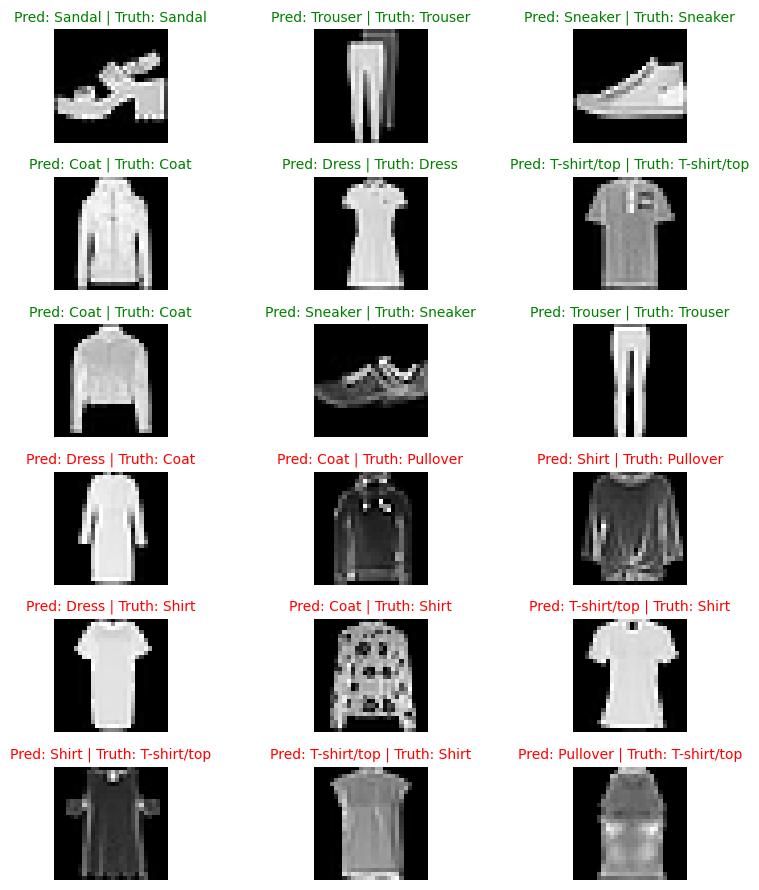

In [48]:
true_samples = []
false_samples = []

for i, sample in enumerate(test_samples):
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'
    
    if pred_label == truth_label and len(true_samples) < 9:
        true_samples.append((sample, title_text, 'g'))
    elif pred_label != truth_label and len(false_samples) < 9:
        false_samples.append((sample, title_text, 'r'))

    if len(true_samples) == 9 and len(false_samples) == 9:
        break

selected_samples = true_samples + false_samples
plt.figure(figsize=(9, 9))
nrows, ncols = 6, 3
for i, (sample, title_text, color) in enumerate(selected_samples):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap='gray')
    plt.title(title_text, fontsize=10, color=color)
    plt.axis(False)
plt.tight_layout()
plt.show()

In [49]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making predictions'):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

<h3>Confusion Matrix</h3>

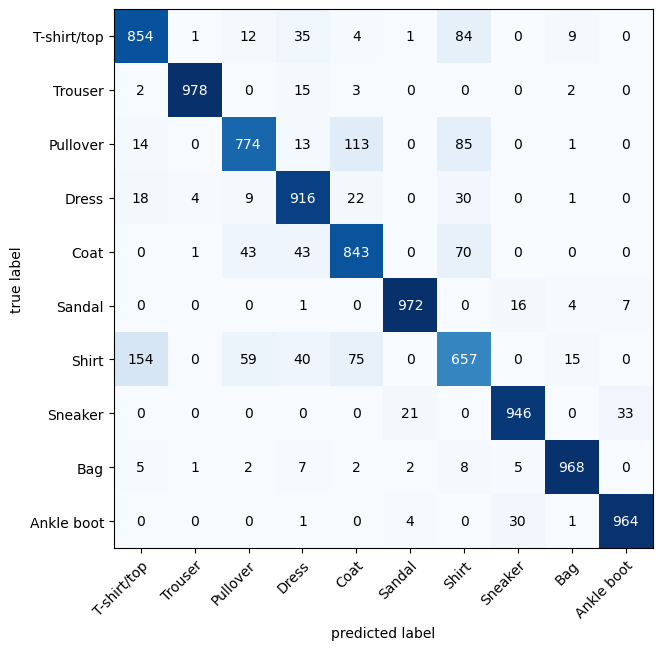

In [50]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10, 7))

<h3>Save Model</h3>

In [51]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = '03_pytorch_computer_vision_model_2.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\03_pytorch_computer_vision_model_2.pth


In [52]:
loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=10)
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))
loaded_model_2 = loaded_model_2.to(device)

In [53]:
torch.manual_seed(42)

loaded_model_2_results = eval_model(model=loaded_model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy)
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3158330023288727,
 'model_acc': 88.7180507183075}

In [54]:
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)